In [64]:
import sys

if True:
    # !pip install -U "jax[cuda12]"
    !pip install jaxkan --no-deps
    !pip install tqdm

if True:
    """
    import os
    os.environ['XLA_FLAGS'] = (
        '--xla_gpu_enable_triton_softmax_fusion=true '
        '--xla_gpu_triton_gemm_any=True '
        '--xla_gpu_enable_async_collectives=true '
        '--xla_gpu_enable_latency_hiding_scheduler=true '
        '--xla_gpu_enable_highest_priority_async_stream=true '
    )
    """
    sys.path.append('/kaggle/input/experiments')

import jax
import jax.numpy as jnp
import numpy as np
import optax

from jaxkan.models.KAN import KAN

from tqdm import tqdm
import matplotlib.pyplot as plt

from Utils import *

jax.devices()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[cuda(id=0)]

In [65]:
import jax
jax.devices()

[cuda(id=0)]

In [66]:
class Config:
    N_INPUT = 2
    X_MIN = -1
    X_MAX = 1
    
    Y_MIN = -1
    Y_MAX = 1
    
    N_SPLINES_INIT = 3 

    BS = 2**14
    BS_BC = 1024
    EPOCHS = 2*10000 # 2 * 10000
    layer_dims = [N_INPUT, 6, 6, 1]
    
r = KeyHandler(0)

In [67]:
def get_pde_Helmholtz(model):
    @jax.jit
    def pde_loss_fn(params, collocs, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}
        
        y = u(collocs)
        u_xx = gradf(u, 0, 2)(collocs)
        u_yy = gradf(u, 1, 2)(collocs)
        
        f = (1-17*jnp.pi**2)*jnp.sin(jnp.pi*collocs[:, 0])*jnp.sin(4*jnp.pi*collocs[:, 1])
        f = f.reshape(-1,1)
        
        D = 1
        pde_residual = u_xx + u_yy + y - f
        
        return pde_residual

    return pde_loss_fn

def get_adaptive_loss(model, pde_loss_fn):
    @jax.jit
    def adaptive_loss(params, collocs, bc_collocs, bc_data, state, loc_w):
        variables = {'params' : params, 'state' : state}
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y

        new_loc_w = []

        eta = jnp.array(0.0001, dtype=float)

        pde_residues = pde_loss_fn(params, collocs, state)
        abs_res = jnp.abs(pde_residues)
        loc_w_pde = ((jnp.array(1.0)-eta)*loc_w[0]) + ((eta*abs_res)/jnp.max(abs_res))

        pde_loss = jnp.mean((pde_residues*loc_w_pde)**2)
        new_loc_w.append(loc_w_pde)
        
        bc_loss = 0
        for idx, bc_colloc in enumerate(bc_collocs):
            bc_residues = u(bc_colloc) - bc_data[idx]
            abs_res = jnp.abs(bc_residues)
            loc_w_bc = ((jnp.array(1.0)-eta)*loc_w[idx+1]) + ((eta*abs_res)/jnp.max(abs_res))
           
            bc_loss += jnp.mean((bc_residues*loc_w_bc)**2) 
            new_loc_w.append(loc_w_bc)
            
        loss = bc_loss + 0.01*pde_loss
        
        return loss, new_loc_w

    return adaptive_loss

def get_vanilla_loss(model, pde_loss_fn):
    @jax.jit
    def vanilla_loss(params, collocs, bc_collocs, bc_data, state, new_loc_w):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}
        
        pde_residual = pde_loss_fn(params, collocs, state)
        
        bc_loss = 0
        for (bc_x, bc_y) in zip(bc_collocs, bc_data):
            bc_loss += jnp.mean((u(bc_x) - bc_y)**2)
        
        loss = jnp.mean(pde_residual**2) + bc_loss
        return loss, new_loc_w

    return vanilla_loss
    
def get_train_step(model, optimizer, loss_fn):
    @jax.jit
    def train_step(params, collocs, bc_collocs, bc_data, opt_state, state, loc_w):
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, new_loc_w), grads = grad_fn(params, collocs, bc_collocs, bc_data, state, loc_w)

        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return params, opt_state, loss, new_loc_w
    
    return train_step

In [68]:
#init model
model = KAN(layer_dims=Config.layer_dims, k=Config.N_SPLINES_INIT, add_bias=True)
collocs = jnp.ones((Config.BS, Config.N_INPUT))
variables = model.init(r.key(), collocs)

schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=Config.EPOCHS,  # Set decay steps to the total number of training steps
    alpha=1e-3             # Final learning rate multiplier
)
# Use AdamW optimizer with the learning rate schedule
optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)  # Added weight_decay for AdamW
opt_state = optimizer.init(variables['params'])

pde_loss = get_pde_Helmholtz(model)
loss_fn = get_adaptive_loss(model, pde_loss)
# loss_fn = get_vanilla_loss(model, pde_loss)
train_step = get_train_step(model, optimizer, loss_fn)

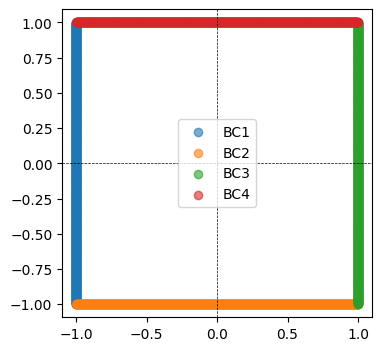

In [69]:
def plot_bc_collocs(bc_collocs):
    """Plots the boundary collocation points."""
    plt.figure(figsize=(4, 4))
    for i, colloc in enumerate(bc_collocs, start=1):
        plt.scatter(colloc[:, 0], colloc[:, 1], label=f'BC{i}', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
# only sample boundary once
BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), Config.BS_BC))
BC1_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), Config.BS_BC))
BC2_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), Config.BS_BC))
BC3_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), Config.BS_BC))
BC4_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

plot_bc_collocs(bc_collocs)

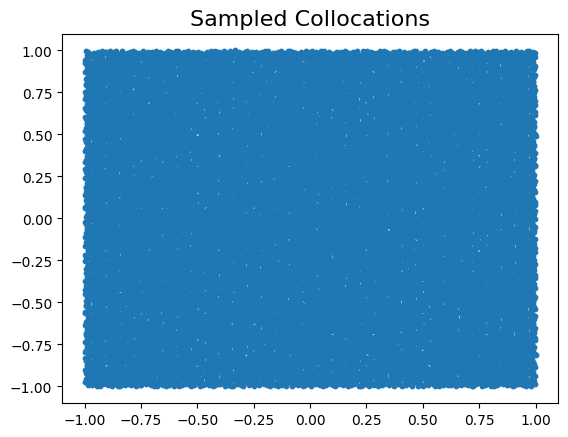

In [70]:
def sample_collocs():
    # sample outside
    collocs = jnp.array(sobol_sample(np.array([Config.X_MIN,Config.Y_MIN]), 
                                     np.array([Config.X_MAX,Config.Y_MAX]), Config.BS))
    return collocs

collocs = sample_collocs()
plt.title('Sampled Collocations', fontsize=16)
plt.scatter(collocs[:, 0], collocs[:, 1], s=10)
plt.show()

In [71]:
N_collocs = collocs.shape[0] + len(bc_collocs) * bc_collocs[0].shape[0]
loc_w = [jnp.ones((collocs.shape[0], 1))] + [jnp.ones((bc_collocs[0].shape[0], 1)) for i in range(len(bc_collocs))]
len(loc_w) # attention weights for collocs and bc are independent

5

In [72]:
%%time
grid_extensions = {}

# train always on same colloc points
collocs = sample_collocs()

losses = []
for i in (pbar:= tqdm(range(Config.EPOCHS))):    
    params, state = variables["params"], variables["state"]
    params, opt_state, loss, loc_w = train_step(params, collocs, bc_collocs, 
                                                 bc_data, opt_state, state, loc_w)
    variables = {'params': params, 'state': state}

    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .4f}")
    losses.append(loss)

Loss  0.0027: 100%|██████████| 20000/20000 [09:12<00:00, 36.19it/s]

CPU times: user 31 s, sys: 1.86 s, total: 32.8 s
Wall time: 9min 12s


In [77]:
"""
%%time
grid_extensions = {}

losses = []
for i in (pbar:= tqdm(range(Config.EPOCHS))):
    collocs = sample_collocs()
    
    params, state = variables["params"], variables["state"]
    params, opt_state, loss, new_loc_w = train_step(params, collocs, bc_collocs, 
                                                    bc_data, opt_state, state, loc_w)
    # update params
    variables = {'params': params, 'state': state}
    
    pbar.set_description(f"Loss {loss: .4f}")
    losses.append(loss)
    
    if i in grid_extensions:
        # refine grid to use grid_extensions[i] splines instead
        n_splines = grid_extensions[i]
        
        updated_variables = model.apply(variables, collocs, n_splines, method=model.update_grids)
        variables = updated_variables.copy()
        # reset opt state, dirty solution
        opt_state = optimizer.init(variables['params'])
"""

'\n%%time\ngrid_extensions = {}\n\nlosses = []\nfor i in (pbar:= tqdm(range(Config.EPOCHS))):\n    collocs = sample_collocs()\n    \n    params, state = variables["params"], variables["state"]\n    params, opt_state, loss, new_loc_w = train_step(params, collocs, bc_collocs, \n                                                    bc_data, opt_state, state, loc_w)\n    #\xa0update params\n    variables = {\'params\': params, \'state\': state}\n    \n    pbar.set_description(f"Loss {loss: .4f}")\n    losses.append(loss)\n    \n    if i in grid_extensions:\n        # refine grid to use grid_extensions[i] splines instead\n        n_splines = grid_extensions[i]\n        \n        updated_variables = model.apply(variables, collocs, n_splines, method=model.update_grids)\n        variables = updated_variables.copy()\n        #\xa0reset opt state, dirty solution\n        opt_state = optimizer.init(variables[\'params\'])\n'

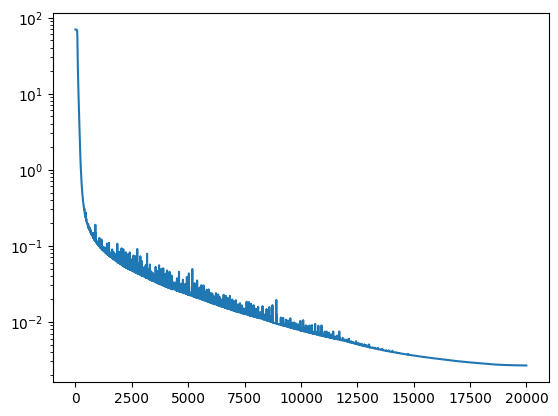

In [78]:
losses
plt.plot(losses)
plt.yscale('log')

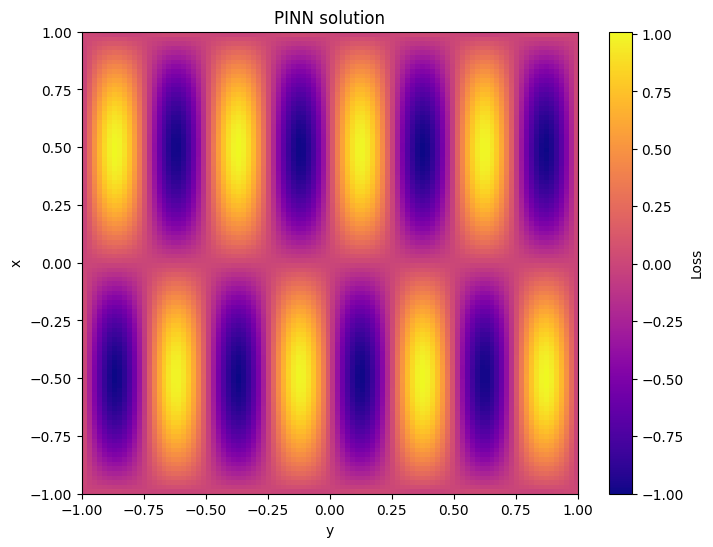

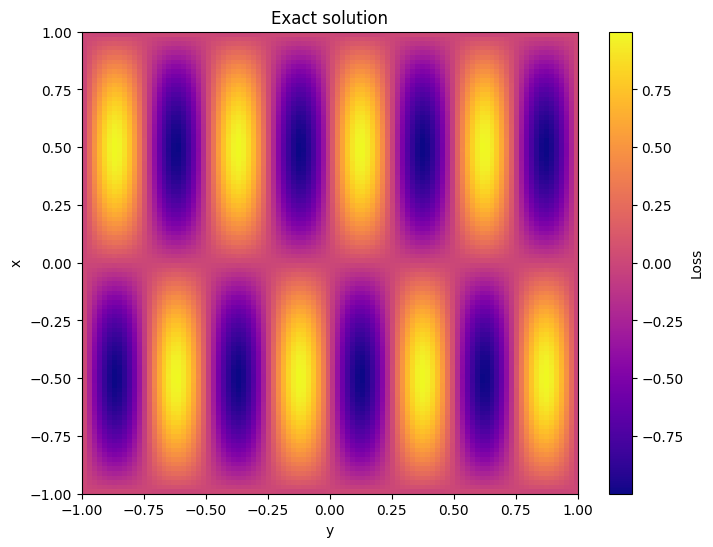

In [87]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(Config.X_MIN, Config.X_MAX, 
                            Config.Y_MIN, Config.Y_MAX), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

params, state = variables["params"], variables["state"]
def u(vec_x):
    y, spl_reg = model.apply(variables, vec_x)
    return y

def exact_u(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.sin(4*jnp.pi*vec_x[:, 1])
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

N = 100 # NxN grid
x_grid = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
y_grid = jnp.linspace(Config.Y_MIN, Config.Y_MAX, N)

# Create a meshgrid of x and t values
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing="ij")
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
collocs = jnp.stack((x_flat, y_flat), axis=-1)

results = u(collocs).reshape(N, N)
loss = pde_loss(params, collocs, state).reshape(N, N)
exact = exact_u(collocs).reshape(N,N)

plot_heatmap(results,"PINN solution")
plot_heatmap(exact,"Exact solution")

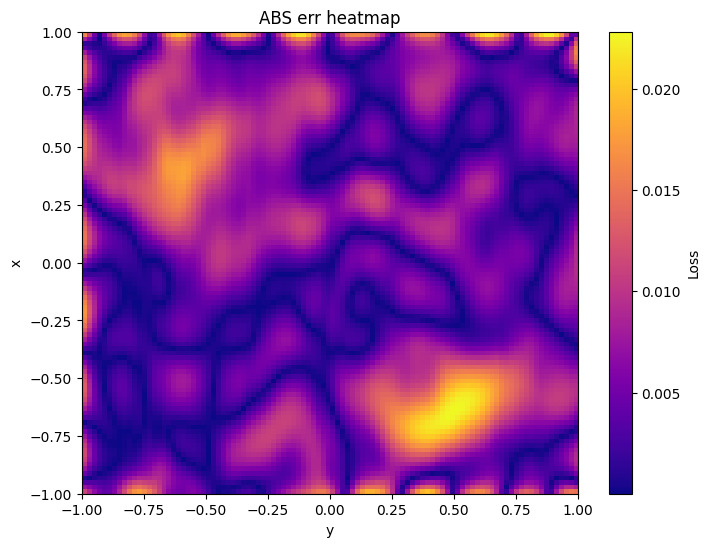

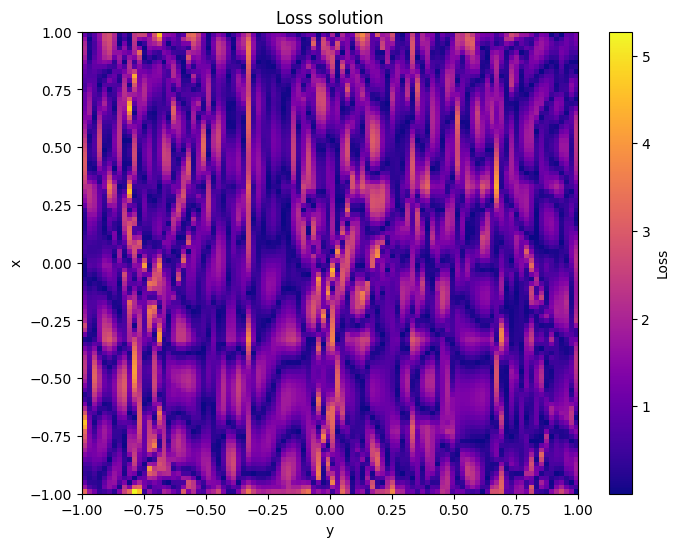

L2 error 1.4714%


In [88]:
plot_heatmap(jnp.abs(results - exact),"ABS err heatmap")
plot_heatmap(jnp.abs(loss),"Loss solution")

l2_err = l2_error(results, exact)
print(f"L2 error {l2_err*100:.4f}%")